# Propensity Matching

In this notebook, we utilize propensity matching methods on our dataset to estimate the effect size of our outcomes. We start by selecting important features with `sklearn`, before using `psmpy` to do the actual matching.

In [1]:
from sklearn.tree import DecisionTreeClassifier
from psmpy import PsmPy
from psmpy.plotting import *
from psmpy.functions import cohenD

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from warnings import warn

import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

import osmnx as ox

from propensity_helpers import *

In [2]:
# Columns NOT to match on
EXCLUDE_LIST = ['YEAR', 'STATE', 'STATEA', 
                'COUNTY', 'COUNTYA', 'TRACTA', 
                'geometry', 'AREANAM',
                'n_311s', 'n_crashes', 'whiteP', 
                'nonWhtP', 'blackP'] # let's try on num_crashes first

# Constant for propensity calculation
PROP_BALANCE = False

# Constants for KNN matching
CALIPER = 0.2
DROP_UNMATCHED = True
KNN_WITH_REPLACEMENT = True
PROP_MATCHER = 'propensity_logit'
N_FEATURES = 15

In [3]:
df = gpd.read_file('../../data/shapes/census_final_fixed.shp')
df.sample(5, random_state=5)

,GISJOIN,YEAR,STATE,STATEA,COUNTY,COUNTYA,TRACTA,AREANAM,whiteP,nonWhtP,...,rfrgNRp,htCntrl,htNCntr,htNRprt,grade,n_crashes,n_311s,nyn,treatment_,geometry
2470,G42010100035ZZ,1940.0,Pennsylvania,42,Philadelphia,101,0035,STCTY-42101 TRACT- 0035-ZZ IN PHILADELPHIA PA,99.86,0.14,...,2.0,860.0,0.0,0.0,B,184.0,423.0,False,B,"POLYGON ((1755933.098 478263.583, 1755927.076 ..."
2395,G42010100032C,1940.0,Pennsylvania,42,Philadelphia,101,0032,STCTY-42101 TRACT- 0032-C IN PHILADELPHIA PA,47.93,52.07,...,41.0,3201.0,10.0,0.0,D,221.0,819.0,True,D_black,"POLYGON ((1750117.078 470663.751, 1750021.283 ..."
1036,G17003100537,1940.0,Illinois,17,Cook,031,0537,STCTY-17031 TRACT- 0537 IN CHICAGO IL,9.26,90.74,...,0.0,1.0,118.0,0.0,D,88.0,46.0,True,D_black,"POLYGON ((689375.29 515595.468, 689371.449 515..."
2509,G42010100040L,1940.0,Pennsylvania,42,Philadelphia,101,0040,STCTY-42101 TRACT- 0040-L IN PHILADELPHIA PA,99.92,0.08,...,45.0,3505.0,18.0,0.0,C,261.0,1444.0,False,C,"POLYGON ((1746055.545 462965.492, 1746043.234 ..."
1109,G17003100610,1940.0,Illinois,17,Cook,031,0610,STCTY-17031 TRACT- 0610 IN CHICAGO IL,99.48,0.52,...,2.0,733.0,0.0,0.0,C,67.0,71.0,False,C,"POLYGON ((692774.651 512527.311, 692748.147 51..."


In [4]:
# Split df by cities -- thankfully we can just split on state.
# compare non-black AB to black CD; requires dropping some rows
#mask = df.treatment_.isin(['A', 'B', 'C_black', 'D_black'])
#df_rel = df.copy()[mask].reset_index(drop=True)
df_rel = df.copy()

regrade_mapper = dict(A=0, B=0, C=1, D=1)

# Fix df.grade if needed
if not df_rel.treatment_[0] in [0, 1]:
     df_rel['treatment_'] = df_rel.grade.apply(lambda x: regrade_mapper[x])

df_rel = df_rel.drop(columns=['grade', 'nyn'])

# Subset down to cities
chicago = df_rel.copy()[df_rel.STATE == 'Illinois']
newyork = df_rel.copy()[df_rel.STATE == 'New York']
philidelphia = df_rel.copy()[df_rel.STATE == 'Pennsylvania']
losangeles = df_rel.copy()[df_rel.STATE == 'California']
detroit = df_rel.copy()[df_rel.STATE == 'Michigan']

In [5]:
# Ensure boundaries are right
chicago = enforce_administrative_boundaries(chicago, "Chicago, Illinois")
newyork = enforce_administrative_boundaries(newyork, "New York, New York")
philidelphia = enforce_administrative_boundaries(philidelphia, "Philadelphia, Pennsylvania")
losangeles = enforce_administrative_boundaries(losangeles, 'Los Angeles, California')
detroit = enforce_administrative_boundaries(detroit, 'Detroit, Michigan')

In [6]:
n_tracts = sum((chicago.shape[0], newyork.shape[0], philidelphia.shape[0], losangeles.shape[0], detroit.shape[0]))
print(n_tracts)

2402


In [7]:
sum((chicago.n_crashes.sum(), newyork.n_crashes.sum(), philidelphia.n_crashes.sum(), losangeles.n_crashes.sum(), detroit.n_crashes.sum()))

1544559.0

In [8]:
sum((chicago.n_311s.sum(), newyork.n_311s.sum(), philidelphia.n_311s.sum(), losangeles.n_311s.sum(), detroit.n_311s.sum()))

3287583.0

## Setup

In [9]:
driving_covariates = dict(covariates=[], city=[])

all_results = {
    'city': [],
    '311_coef': [],
    '311_se': [],
    '311_p': [],
    'crash_coef': [],
    'crash_se': [],
    'crash_p': []
}

## Chicago

In [10]:
covariates_chicago = feature_selection(chicago)
#display_cor_plot(chicago, covariates)

driving_covariates['city'].append('Chicago')
driving_covariates['covariates'].append(covariates_chicago)


chicago_psmpy = make_psmpy(chicago[covariates_chicago + ['n_crashes', 'treatment_', 'GISJOIN']], treatment='treatment_',
                 outcome='n_crashes')

chicago_psmpy.logistic_ps(balance=PROP_BALANCE)

chicago_psmpy.knn_matched(matcher=PROP_MATCHER, 
                          replacement=KNN_WITH_REPLACEMENT, caliper=CALIPER,
                          drop_unmatched=DROP_UNMATCHED)

Classifier scored a 1.0 on full dataset


c:\Users\wimer\github\personal\thesis\notebooks\result_notebooks\propensity_helpers.py:98: UserWarning: Found NAs in covariates, dropping. Lost 14 observations out of 921
  warn(f"Found NAs in covariates, dropping. Lost {old_size-new_size} observations out of {old_size}")
c:\Python311\Lib\site-packages\psmpy\psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False')


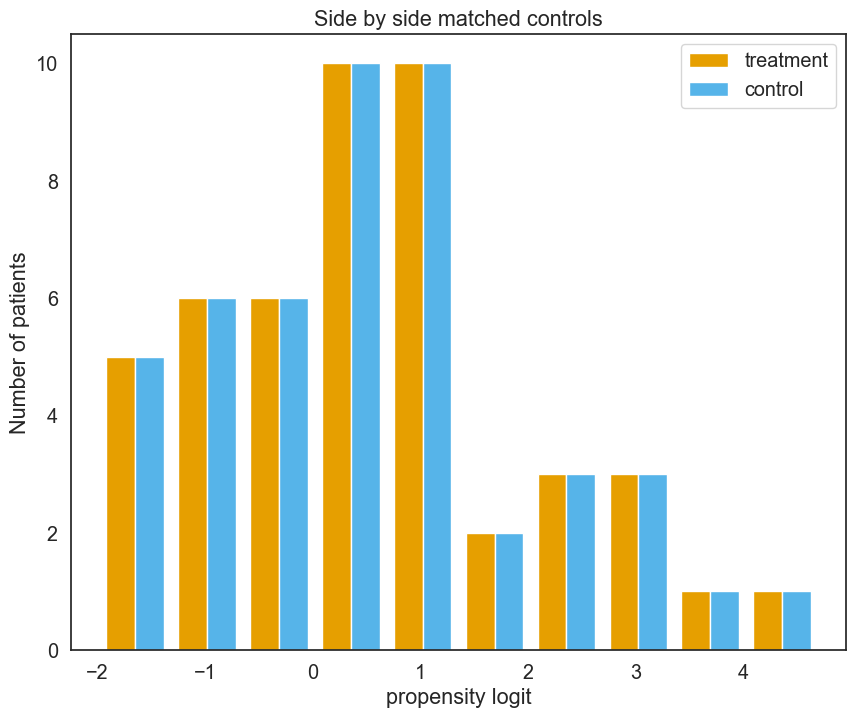

In [11]:
chicago_psmpy.plot_match()

c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


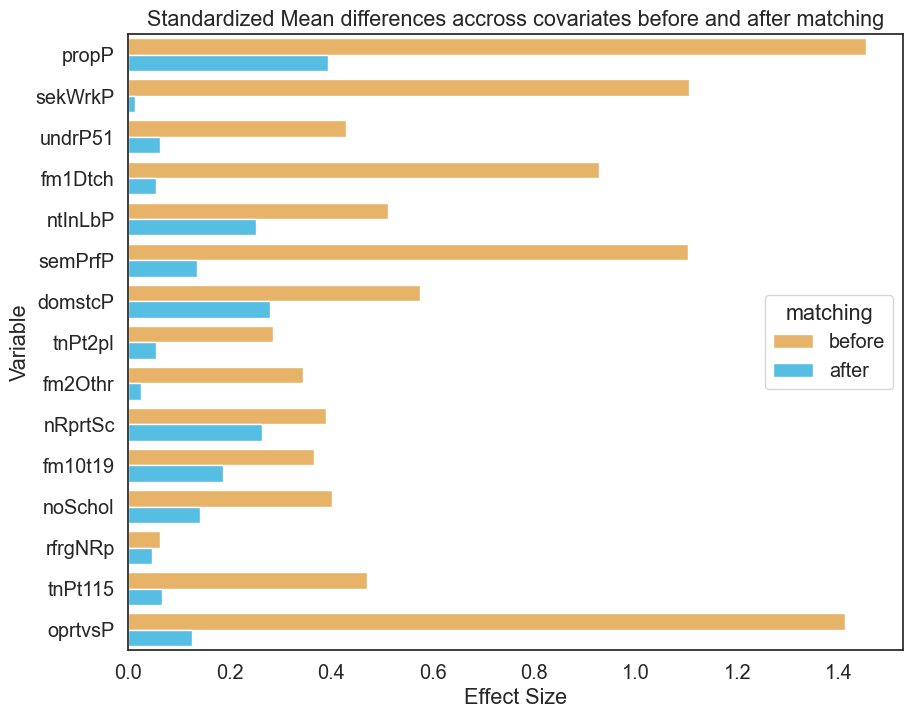

In [12]:
chicago_psmpy.effect_size_plot()

In [13]:
chicago_matched = retrieve_matches(chicago_psmpy, chicago, treatment='treatment_')
chicago_matched['log_exposure'] = np.log(5)

run_models_update_results(chicago_matched, all_results, 'Chicago')

Estimating an alpha of 0.8760734444545301 for crashes
Checking Asumptions of Negative Binomial Model for 311s:
    	Mean 311s: 790.3291139240506
    	Variance of 311s: 337218.09542356385
    
Estimating an alpha of 0.5386118087307109 for 311s
                 Generalized Linear Model Regression Results                  
Dep. Variable:              n_crashes   No. Observations:                   79
Model:                            GLM   Df Residuals:                       77
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -601.55
Date:                Wed, 26 Mar 2025   Deviance:                       46.388
Time:                        13:36:27   Pearson chi2:                     65.1
No. Iterations:                     5   Pseudo R-squ. (CS):            0.04525
Covariance Type:            nonrobust         

In [14]:
all_results

{'city': ['Chicago'],
 '311_coef': [-0.3295655501158682],
 '311_se': [0.1684162334835936],
 '311_p': [0.05036493641983],
 'crash_coef': [-0.417394776862851],
 'crash_se': [0.214690472538398],
 'crash_p': [0.0518749537083297]}

## NYC

In [15]:
covariates_nyc = feature_selection(newyork)

driving_covariates['city'].append('New York City')
driving_covariates['covariates'].append(covariates_nyc)

newyork_psmpy = make_psmpy(newyork[covariates_nyc + ['n_crashes', 'treatment_', 'GISJOIN']], treatment='treatment_',
                           outcome='n_crashes')

newyork_psmpy.logistic_ps(balance=PROP_BALANCE)

newyork_psmpy.knn_matched(matcher=PROP_MATCHER, 
                          replacement=KNN_WITH_REPLACEMENT, caliper=CALIPER,
                          drop_unmatched=DROP_UNMATCHED)

Classifier scored a 1.0 on full dataset


c:\Python311\Lib\site-packages\psmpy\psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False')


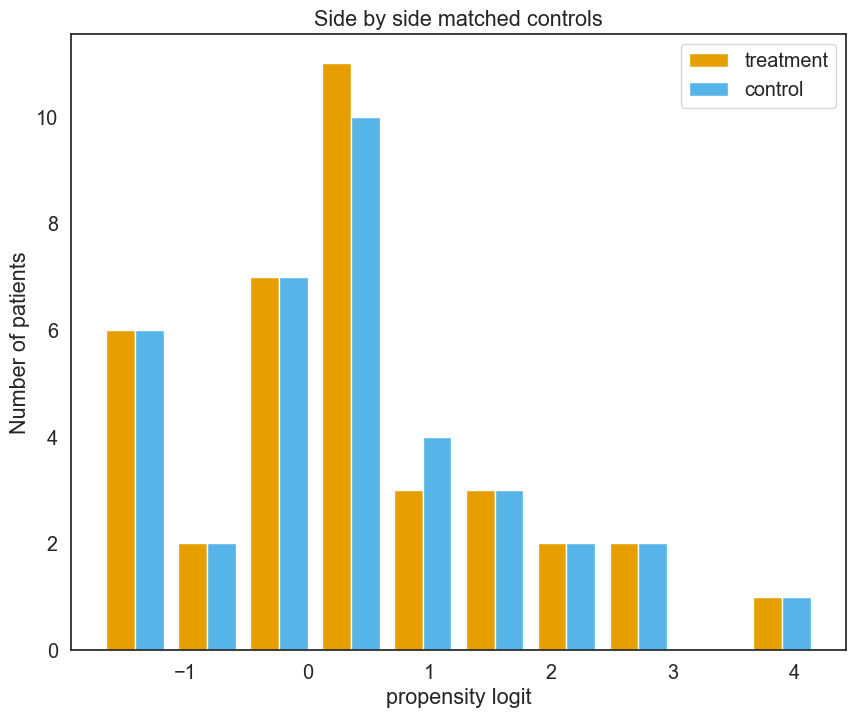

In [16]:
newyork_psmpy.plot_match()

c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


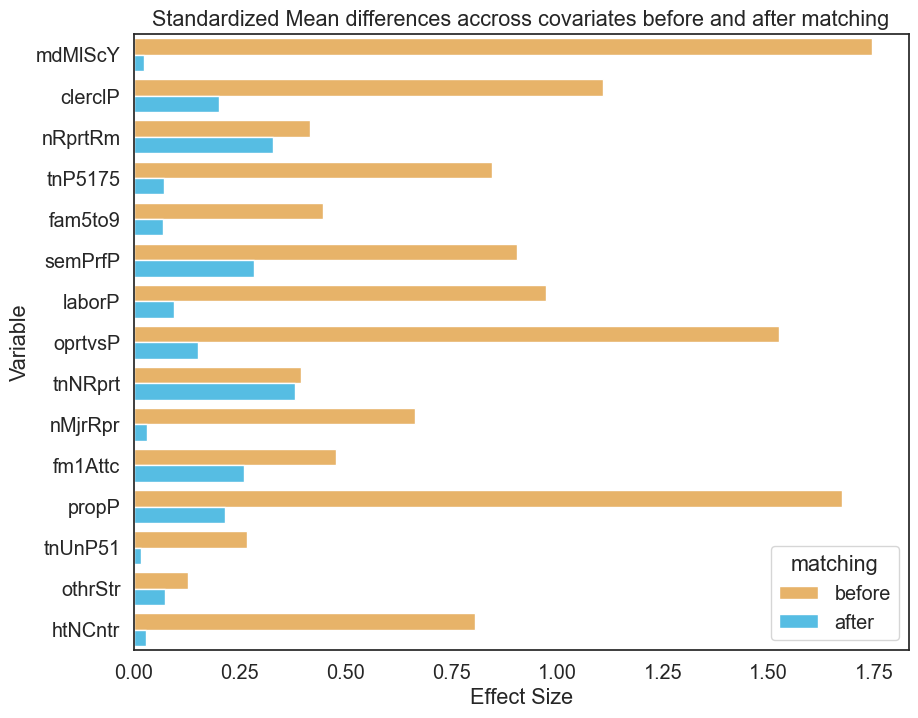

In [17]:
newyork_psmpy.effect_size_plot()

In [18]:
newyork_matched = retrieve_matches(newyork_psmpy, newyork)
newyork_matched['log_exposure'] = np.log(5)

run_models_update_results(newyork_matched, all_results, 'New York')

all_results

Estimating an alpha of 0.4337102505740691 for crashes
Checking Asumptions of Negative Binomial Model for 311s:
    	Mean 311s: 975.1612903225806
    	Variance of 311s: 512194.7604442094
    
Estimating an alpha of 0.5375942176108269 for 311s
                 Generalized Linear Model Regression Results                  
Dep. Variable:              n_crashes   No. Observations:                   62
Model:                            GLM   Df Residuals:                       60
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -526.89
Date:                Wed, 26 Mar 2025   Deviance:                       62.154
Time:                        13:36:28   Pearson chi2:                     56.4
No. Iterations:                     5   Pseudo R-squ. (CS):            0.04650
Covariance Type:            nonrobust          

{'city': ['Chicago', 'New York'],
 '311_coef': [-0.3295655501158682, 0.2681657593039798],
 '311_se': [0.1684162334835936, 0.1899993571874912],
 '311_p': [0.05036493641983, 0.15812566910986448],
 'crash_coef': [-0.417394776862851, 0.29086894289114573],
 'crash_se': [0.214690472538398, 0.170587165445037],
 'crash_p': [0.0518749537083297, 0.08817493711738246]}

## Detroit

In [19]:
covariates_detroit = feature_selection(detroit)

driving_covariates['city'].append('Detroit')
driving_covariates['covariates'].append(covariates_detroit)

detroit_psmpy = make_psmpy(detroit[covariates_detroit + ['n_crashes', 'treatment_', 'GISJOIN']],
                           treatment='treatment_', outcome='n_crashes')

detroit_psmpy.logistic_ps(balance=PROP_BALANCE)
detroit_psmpy.knn_matched(matcher=PROP_MATCHER,
                          replacement=KNN_WITH_REPLACEMENT, caliper=CALIPER,
                          drop_unmatched=DROP_UNMATCHED)

Classifier scored a 1.0 on full dataset


c:\Users\wimer\github\personal\thesis\notebooks\result_notebooks\propensity_helpers.py:98: UserWarning: Found NAs in covariates, dropping. Lost 1 observations out of 419
  warn(f"Found NAs in covariates, dropping. Lost {old_size-new_size} observations out of {old_size}")
c:\Users\wimer\github\personal\thesis\notebooks\result_notebooks\propensity_helpers.py:102: UserWarning: Found missing outcome values. Filling with 0
  warn("Found missing outcome values. Filling with 0")
c:\Python311\Lib\site-packages\psmpy\psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatche

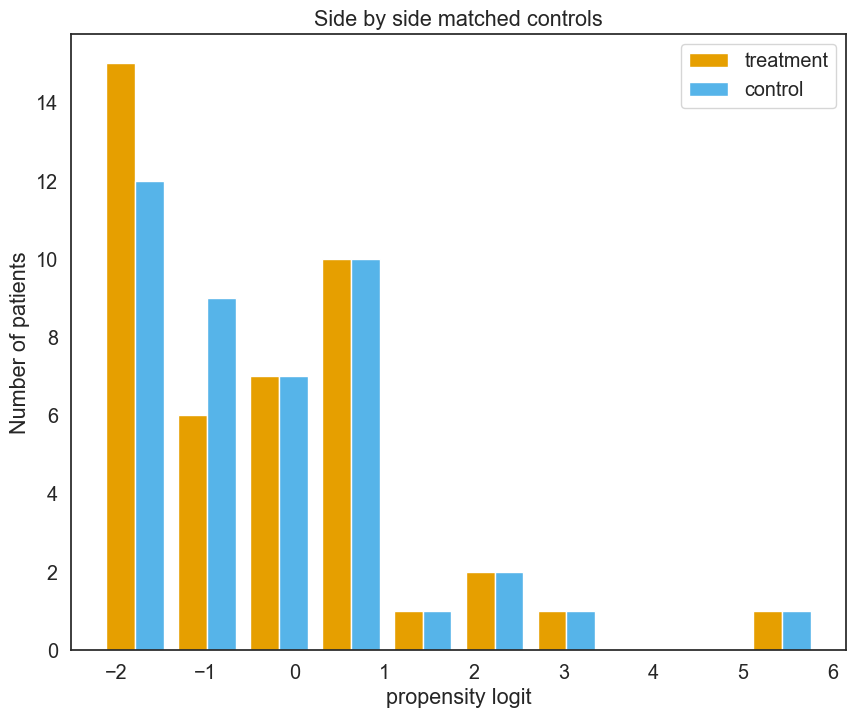

In [20]:
detroit_psmpy.plot_match()

c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


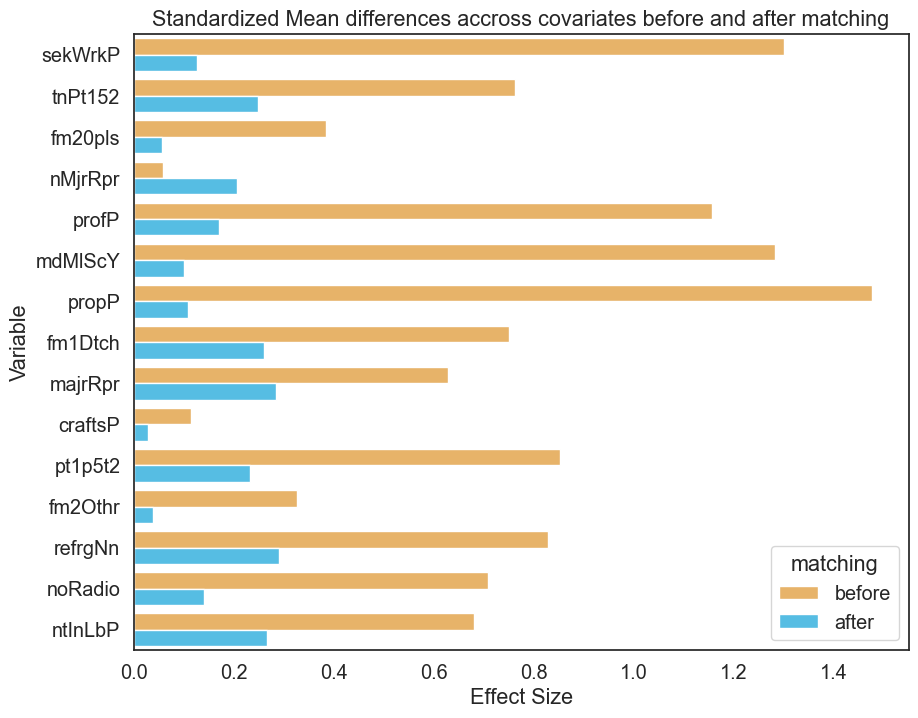

In [21]:
detroit_psmpy.effect_size_plot()

In [22]:
detroit_matched = retrieve_matches(detroit_psmpy, detroit)
detroit_matched['log_exposure'] = np.log(5)

run_models_update_results(detroit_matched, all_results, 'Detroit')

all_results

Estimating an alpha of 0.6156737217880526 for crashes
Checking Asumptions of Negative Binomial Model for 311s:
    	Mean 311s: 14.923076923076923
    	Variance of 311s: 184.22926093514332
    
Estimating an alpha of 0.7602493649176113 for 311s
                 Generalized Linear Model Regression Results                  
Dep. Variable:              n_crashes   No. Observations:                   58
Model:                            GLM   Df Residuals:                       56
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -419.20
Date:                Wed, 26 Mar 2025   Deviance:                       96.253
Time:                        13:36:29   Pearson chi2:                     54.0
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01740
Covariance Type:            nonrobust        

{'city': ['Chicago', 'New York', 'Detroit'],
 '311_coef': [-0.3295655501158682, 0.2681657593039798, -0.4769957592475861],
 '311_se': [0.1684162334835936, 0.1899993571874912, 0.28152039130150347],
 '311_p': [0.05036493641983, 0.15812566910986448, 0.09019765848766458],
 'crash_coef': [-0.417394776862851, 0.29086894289114573, -0.23269150678843536],
 'crash_se': [0.214690472538398, 0.170587165445037, 0.22676683782356427],
 'crash_p': [0.0518749537083297, 0.08817493711738246, 0.3048318667764611]}

## LA

In [23]:
covariates_la = feature_selection(losangeles)

driving_covariates['city'].append('Los Angeles')
driving_covariates['covariates'].append(covariates_la)

losangeles_psmpy = make_psmpy(losangeles[covariates_la + ['n_crashes', 'treatment_', 'GISJOIN']], 
                              treatment='treatment_', outcome='n_crashes')

losangeles_psmpy.logistic_ps(balance=PROP_BALANCE)

losangeles_psmpy.knn_matched(matcher=PROP_MATCHER, 
                          replacement=KNN_WITH_REPLACEMENT, caliper=CALIPER,
                          drop_unmatched=DROP_UNMATCHED)

Classifier scored a 1.0 on full dataset


c:\Users\wimer\github\personal\thesis\notebooks\result_notebooks\propensity_helpers.py:98: UserWarning: Found NAs in covariates, dropping. Lost 1 observations out of 352
  warn(f"Found NAs in covariates, dropping. Lost {old_size-new_size} observations out of {old_size}")
c:\Users\wimer\github\personal\thesis\notebooks\result_notebooks\propensity_helpers.py:102: UserWarning: Found missing outcome values. Filling with 0
  warn("Found missing outcome values. Filling with 0")
c:\Python311\Lib\site-packages\psmpy\psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatche

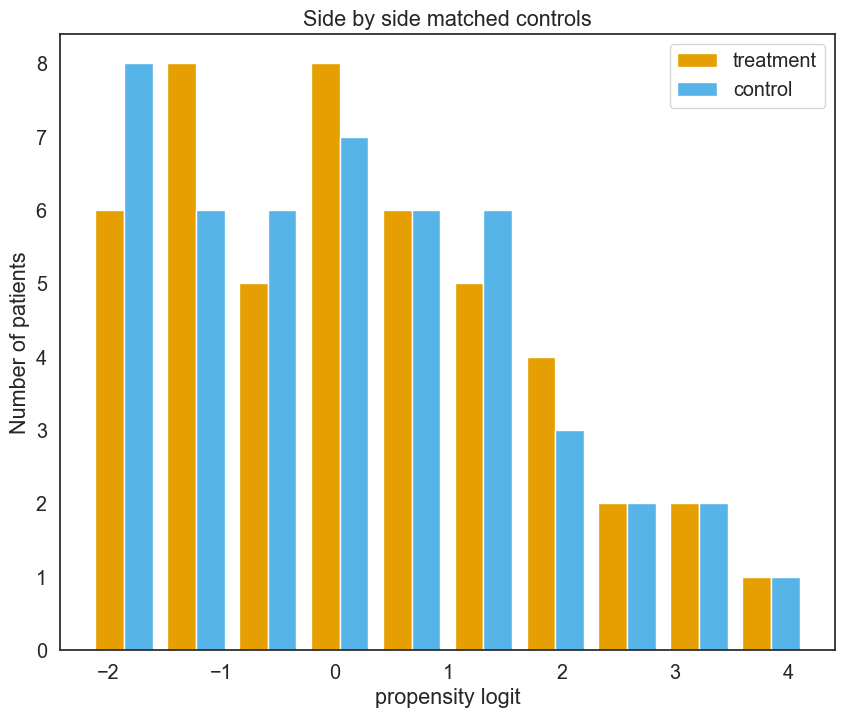

In [24]:
losangeles_psmpy.plot_match()

c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


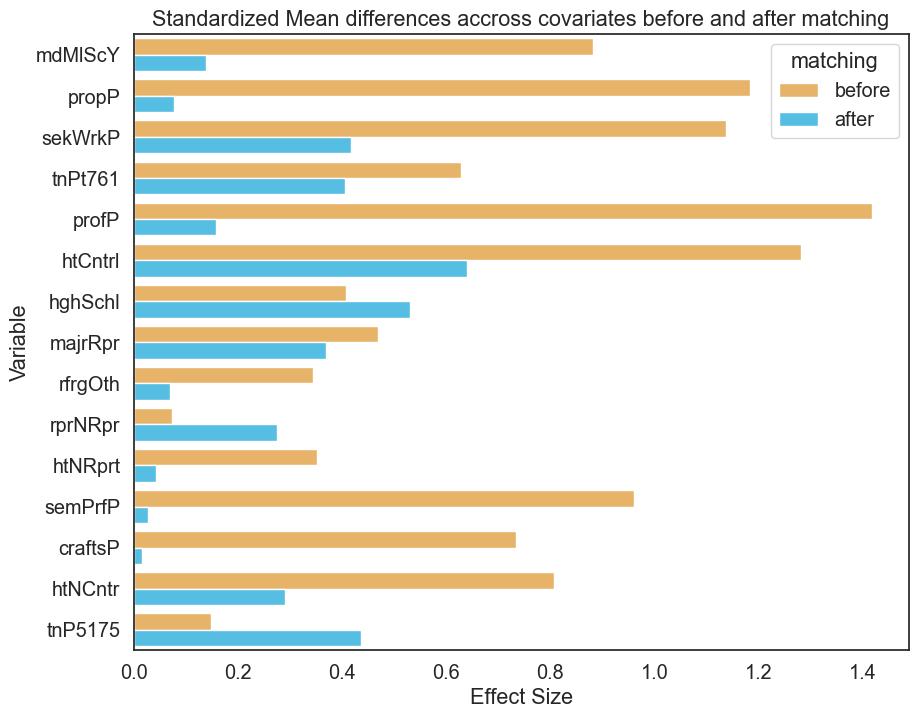

In [25]:
losangeles_psmpy.effect_size_plot()

In [26]:
losangeles_matched = retrieve_matches(losangeles_psmpy, losangeles)
losangeles_matched['log_exposure'] = np.log(5)

run_models_update_results(losangeles_matched, all_results, 'Los Angeles')

all_results

Estimating an alpha of 2.5054168385838835 for crashes
Checking Asumptions of Negative Binomial Model for 311s:
    	Mean 311s: 5370.072463768116
    	Variance of 311s: 100850812.18584827
    
Estimating an alpha of 3.497002816341875 for 311s
                 Generalized Linear Model Regression Results                  
Dep. Variable:              n_crashes   No. Observations:                   69
Model:                            GLM   Df Residuals:                       67
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -515.74
Date:                Wed, 26 Mar 2025   Deviance:                       48.268
Time:                        13:36:31   Pearson chi2:                     70.1
No. Iterations:                     6   Pseudo R-squ. (CS):          0.0004756
Covariance Type:            nonrobust          

{'city': ['Chicago', 'New York', 'Detroit', 'Los Angeles'],
 '311_coef': [-0.3295655501158682,
  0.2681657593039798,
  -0.4769957592475861,
  0.06690786040996742],
 '311_se': [0.1684162334835936,
  0.1899993571874912,
  0.28152039130150347,
  0.46129358729358916],
 '311_p': [0.05036493641983,
  0.15812566910986448,
  0.09019765848766458,
  0.8846761435170781],
 'crash_coef': [-0.417394776862851,
  0.29086894289114573,
  -0.23269150678843536,
  0.07106540539856228],
 'crash_se': [0.214690472538398,
  0.170587165445037,
  0.22676683782356427,
  0.3933509185186149],
 'crash_p': [0.0518749537083297,
  0.08817493711738246,
  0.3048318667764611,
  0.8566292121152989]}

## Philadelphia

In [27]:
covariates_phili = feature_selection(philidelphia)

driving_covariates['city'].append('Philadelphia')
driving_covariates['covariates'].append(covariates_phili)

philidelphia_psmpy = make_psmpy(philidelphia[covariates_phili + ['n_crashes', 'treatment_', 'GISJOIN']], 
                                treatment='treatment_', outcome='n_crashes')

philidelphia_psmpy.logistic_ps(balance=PROP_BALANCE)

philidelphia_psmpy.knn_matched(matcher=PROP_MATCHER, 
                          replacement=KNN_WITH_REPLACEMENT, caliper=CALIPER,
                          drop_unmatched=DROP_UNMATCHED)

Classifier scored a 1.0 on full dataset


c:\Users\wimer\github\personal\thesis\notebooks\result_notebooks\propensity_helpers.py:98: UserWarning: Found NAs in covariates, dropping. Lost 4 observations out of 369
  warn(f"Found NAs in covariates, dropping. Lost {old_size-new_size} observations out of {old_size}")
c:\Users\wimer\github\personal\thesis\notebooks\result_notebooks\propensity_helpers.py:102: UserWarning: Found missing outcome values. Filling with 0
  warn("Found missing outcome values. Filling with 0")
c:\Python311\Lib\site-packages\psmpy\psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatche

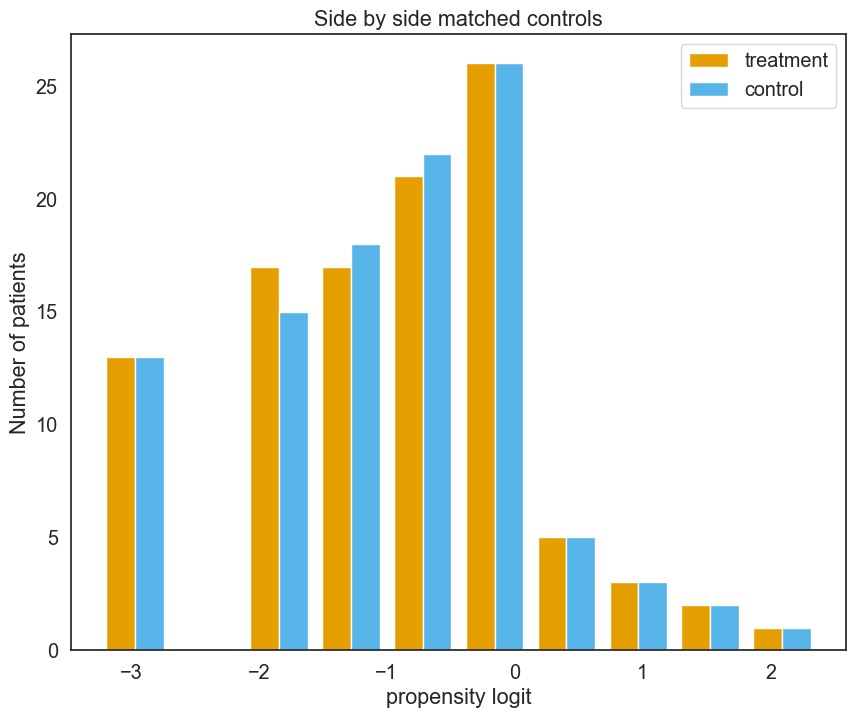

In [28]:
philidelphia_psmpy.plot_match()

c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


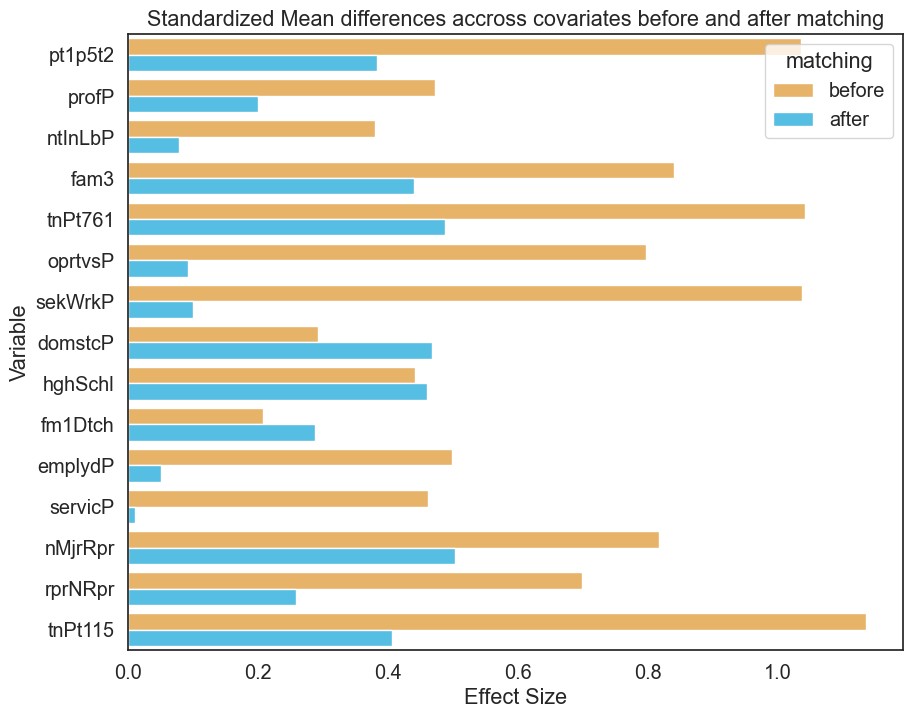

In [29]:
philidelphia_psmpy.effect_size_plot()

In [30]:
philidelphia_matched = retrieve_matches(philidelphia_psmpy, philidelphia)
philidelphia_matched['log_exposure'] = np.log(5)

run_models_update_results(philidelphia_matched, all_results, 'Philidelphia')

all_results

Estimating an alpha of 0.6097407995399545 for crashes
Checking Asumptions of Negative Binomial Model for 311s:
    	Mean 311s: 413.1458333333333
    	Variance of 311s: 113314.64291958042
    
Estimating an alpha of 0.6614437946050646 for 311s
                 Generalized Linear Model Regression Results                  
Dep. Variable:              n_crashes   No. Observations:                  143
Model:                            GLM   Df Residuals:                      141
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -780.28
Date:                Wed, 26 Mar 2025   Deviance:                       178.50
Time:                        13:36:32   Pearson chi2:                     142.
No. Iterations:                     5   Pseudo R-squ. (CS):          0.0002072
Covariance Type:            nonrobust         

{'city': ['Chicago', 'New York', 'Detroit', 'Los Angeles', 'Philidelphia'],
 '311_coef': [-0.3295655501158682,
  0.2681657593039798,
  -0.4769957592475861,
  0.06690786040996742,
  0.0961597243923287],
 '311_se': [0.1684162334835936,
  0.1899993571874912,
  0.28152039130150347,
  0.46129358729358916,
  0.1527781333178616],
 '311_p': [0.05036493641983,
  0.15812566910986448,
  0.09019765848766458,
  0.8846761435170781,
  0.5290822172697925],
 'crash_coef': [-0.417394776862851,
  0.29086894289114573,
  -0.23269150678843536,
  0.07106540539856228,
  -0.025520889282123066],
 'crash_se': [0.214690472538398,
  0.170587165445037,
  0.22676683782356427,
  0.3933509185186149,
  0.14798879718575594],
 'crash_p': [0.0518749537083297,
  0.08817493711738246,
  0.3048318667764611,
  0.8566292121152989,
  0.8630825915586633]}

## Save Features, Results

In [31]:
results = pd.DataFrame(all_results)
rows = np.array(driving_covariates['covariates']).T
driving_covariates = pd.DataFrame(rows, columns=driving_covariates['city'], index=[i for i in range(15)])

results.to_csv('../../data/outcomes/results_grade.csv')
driving_covariates.to_csv('../../data/outcomes/covariates_grade.csv')

In [32]:
driving_covariates

,Chicago,New York City,Detroit,Los Angeles,Philadelphia
0,propP,mdMlScY,sekWrkP,mdMlScY,pt1p5t2
1,sekWrkP,clerclP,tnPt152,propP,profP
2,undrP51,nRprtRm,fm20pls,sekWrkP,ntInLbP
3,fm1Dtch,tnP5175,nMjrRpr,tnPt761,fam3
4,ntInLbP,fam5to9,profP,profP,tnPt761
5,semPrfP,semPrfP,mdMlScY,htCntrl,oprtvsP
6,domstcP,laborP,propP,hghSchl,sekWrkP
7,tnPt2pl,oprtvsP,fm1Dtch,majrRpr,domstcP
8,fm2Othr,tnNRprt,majrRpr,rfrgOth,hghSchl
9,nRprtSc,nMjrRpr,craftsP,rprNRpr,fm1Dtch


## Pool Values

In [33]:
from statsmodels.stats.meta_analysis import combine_effects
results = pd.DataFrame(all_results)

# Crashes
log_crash_irr = results.crash_coef # Coefficients are just Log irr -- renamed for convenience
crash_variances = results.crash_se ** 2 # this probably works

combined_effects_models = combine_effects(log_crash_irr, crash_variances, 
                                                method_re='dl')


combined_effects_models.i2, combined_effects_models.tau2

(0.47768501131916796, 0.03848160381444803)

In [34]:
combined_effects_models.summary_frame()

,eff,sd_eff,ci_low,ci_upp,w_fe,w_re
0,-0.417395,0.214690,-0.838180,0.003391,0.169989,0.198787
1,0.290869,0.170587,-0.043476,0.625214,0.269249,0.248768
2,-0.232692,0.226767,-0.677146,0.211763,0.152366,0.186999
3,0.071065,0.393351,-0.699888,0.842019,0.050639,0.087016
4,-0.025521,0.147989,-0.315574,0.264532,0.357757,0.278429
fixed effect,-0.033622,0.088516,-0.207111,0.139866,1.000000,NaN
random effect,-0.055049,0.129662,-0.309181,0.199083,NaN,1.000000
fixed effect wls,-0.033622,0.122478,-0.273674,0.206430,1.000000,NaN
random effect wls,-0.055049,0.125892,-0.301792,0.191694,NaN,1.000000


In [35]:
eff, sd_eff = combined_effects_models.summary_frame().loc['random effect wls', ['eff', 'sd_eff']]

all_results['city'].append('Pooled')
all_results['crash_coef'].append(eff)
all_results['crash_se'].append(sd_eff)

In [36]:
# Crashes
log_311_irr = results['311_coef'] # Coefficients are just Log irr -- renamed for convenience
var_311 = results['311_se'] ** 2 # this probably works

combined_effects_models = combine_effects(log_311_irr, var_311, method_re='dl')

combined_effects_models.i2, combined_effects_models.tau2


(0.5474328501641955, 0.053518664361112155)

In [37]:
combined_effects_models.summary_frame()

,eff,sd_eff,ci_low,ci_upp,w_fe,w_re
0,-0.329566,0.168416,-0.659655,0.000524,0.286361,0.256199
1,0.268166,0.189999,-0.104226,0.640558,0.224998,0.234084
2,-0.476996,0.281520,-1.028766,0.074774,0.102486,0.158002
3,0.066908,0.461294,-0.837211,0.971027,0.038170,0.078774
4,0.096160,0.152778,-0.203280,0.395599,0.347985,0.272942
fixed effect,-0.046907,0.090124,-0.223547,0.129733,1.000000,NaN
random effect,-0.065510,0.144839,-0.349389,0.218368,NaN,1.000000
fixed effect wls,-0.046907,0.133968,-0.309479,0.215664,1.000000,NaN
random effect wls,-0.065510,0.140708,-0.341292,0.210271,NaN,1.000000


In [38]:
eff, sd_eff = combined_effects_models.summary_frame().loc['random effect wls', ['eff', 'sd_eff']]

all_results['311_coef'].append(eff)
all_results['311_se'].append(sd_eff)

In [39]:
all_results['crash_p'].append(pd.NA)
all_results['311_p'].append(pd.NA)

In [40]:
results = pd.DataFrame(all_results)


          IRR: ----
          	0    0.719236
1    1.307564
2    0.620645
3    1.069197
4    1.100935
5    0.936589
Name: 311_coef, dtype: float64
          Errors: ----
          	[0    0.202210
1    0.406549
2    0.263201
3    0.636288
4    0.284890
5    0.225742
dtype: float64, 0    0.281294
1    0.589988
2    0.457006
3    1.571501
4    0.384347
5    0.297430
dtype: float64]
          


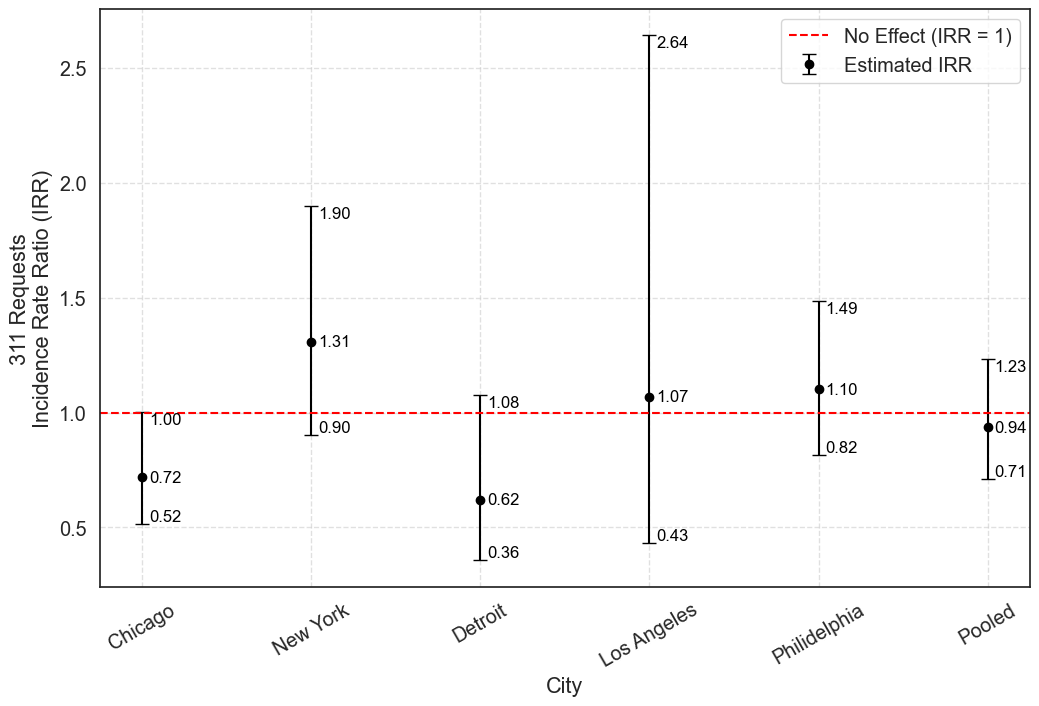

In [41]:

plot_estimates(results, '311', ylabel='311 Requests\nIncidence Rate Ratio (IRR)', title="")


          IRR: ----
          	0    0.658761
1    1.337589
2    0.792398
3    1.073651
4    0.974802
5    0.946439
Name: crash_coef, dtype: float64
          Errors: ----
          	[0    0.226267
1    0.380139
2    0.284337
3    0.577018
4    0.245436
5    0.206951
dtype: float64, 0    0.344644
1    0.531067
2    0.443467
3    1.247430
4    0.328026
5    0.264867
dtype: float64]
          


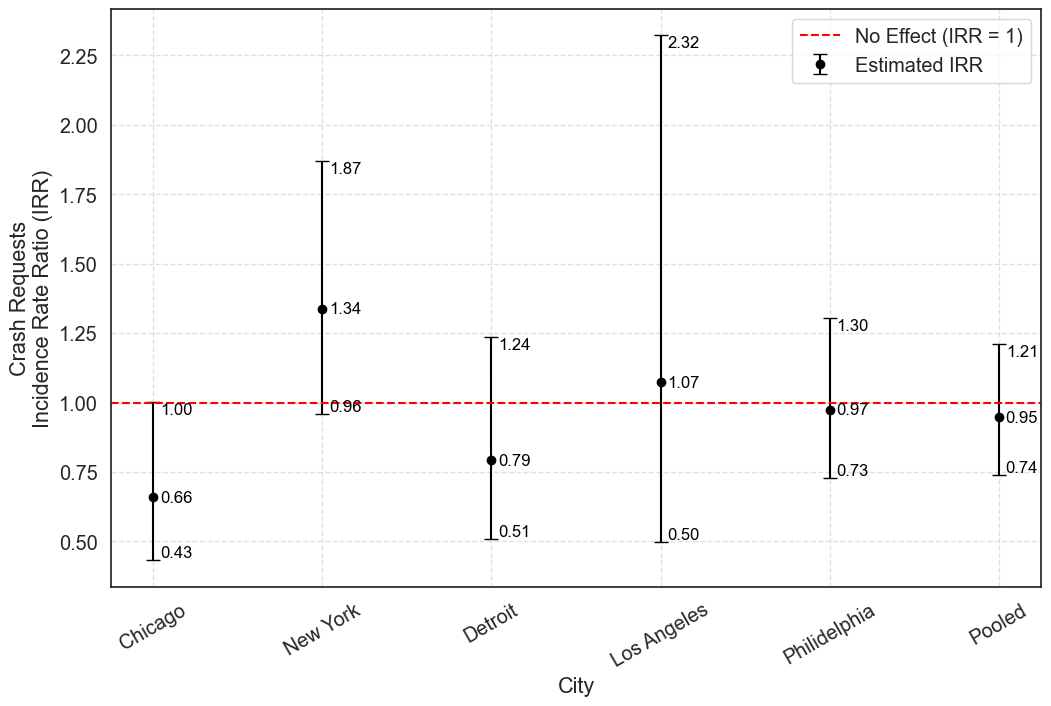

In [42]:
plot_estimates(results, 'crash', ylabel='Crash Requests\nIncidence Rate Ratio (IRR)', title="")

## Collated

In [43]:
results

,city,311_coef,311_se,311_p,crash_coef,crash_se,crash_p
0,Chicago,-0.329566,0.168416,0.050365,-0.417395,0.214690,0.051875
1,New York,0.268166,0.189999,0.158126,0.290869,0.170587,0.088175
2,Detroit,-0.476996,0.281520,0.090198,-0.232692,0.226767,0.304832
3,Los Angeles,0.066908,0.461294,0.884676,0.071065,0.393351,0.856629
4,Philidelphia,0.096160,0.152778,0.529082,-0.025521,0.147989,0.863083
5,Pooled,-0.065510,0.140708,<NA>,-0.055049,0.125892,<NA>


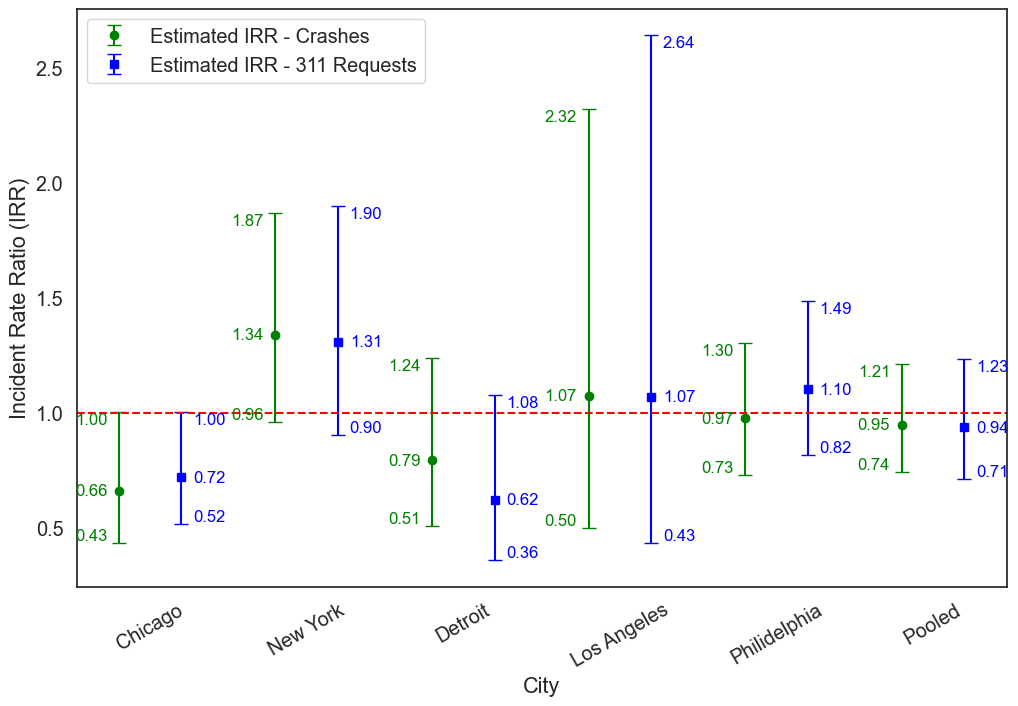

In [44]:
plot_both_estimates(results, "crash", "311", 
               "Crashes", "311 Requests", 
               "Incident Rate Ratio (IRR)", "")

## Naive Analysis

In which we just Do The Pipeline but on all the data

In [45]:
naive = pd.concat([chicago, newyork, philidelphia, losangeles, detroit], axis=0, ignore_index=True)

In [46]:
covariates_naive = feature_selection(naive)

#driving_covariates['city'].append('New York City')
#driving_covariates['covariates'].append(covariates_nyc)

naive_psmpy = make_psmpy(naive[covariates_naive + ['n_crashes', 'treatment_', 'GISJOIN']], treatment='treatment_',
                           outcome='n_crashes')

naive_psmpy.logistic_ps(balance=PROP_BALANCE)

naive_psmpy.knn_matched(matcher=PROP_MATCHER, 
                          replacement=KNN_WITH_REPLACEMENT, caliper=CALIPER,
                          drop_unmatched=DROP_UNMATCHED)

Classifier scored a 1.0 on full dataset


c:\Users\wimer\github\personal\thesis\notebooks\result_notebooks\propensity_helpers.py:98: UserWarning: Found NAs in covariates, dropping. Lost 20 observations out of 2402
  warn(f"Found NAs in covariates, dropping. Lost {old_size-new_size} observations out of {old_size}")
c:\Users\wimer\github\personal\thesis\notebooks\result_notebooks\propensity_helpers.py:102: UserWarning: Found missing outcome values. Filling with 0
  warn("Found missing outcome values. Filling with 0")
c:\Python311\Lib\site-packages\psmpy\psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatc

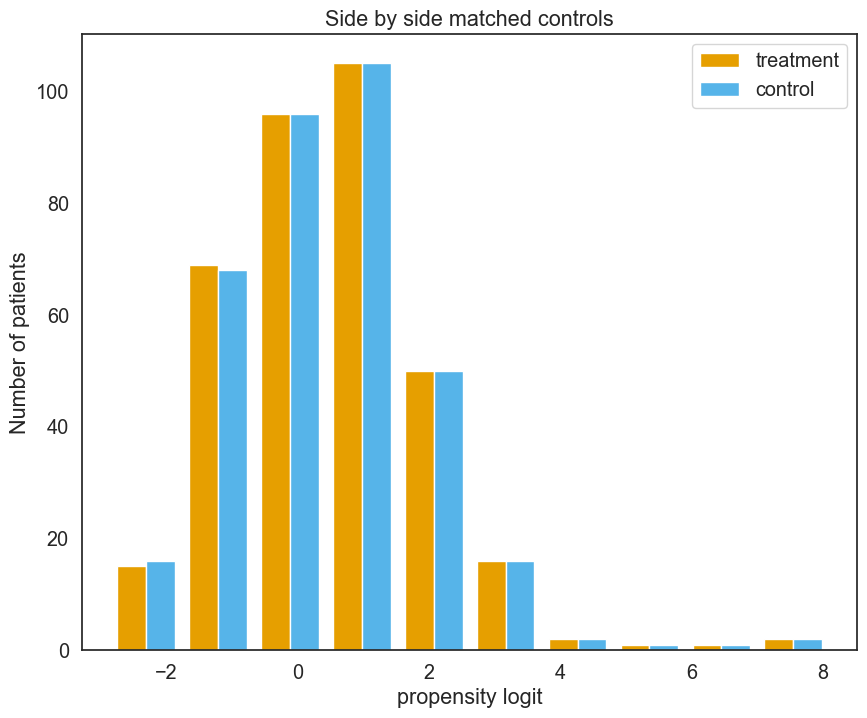

In [47]:
naive_psmpy.plot_match()

c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


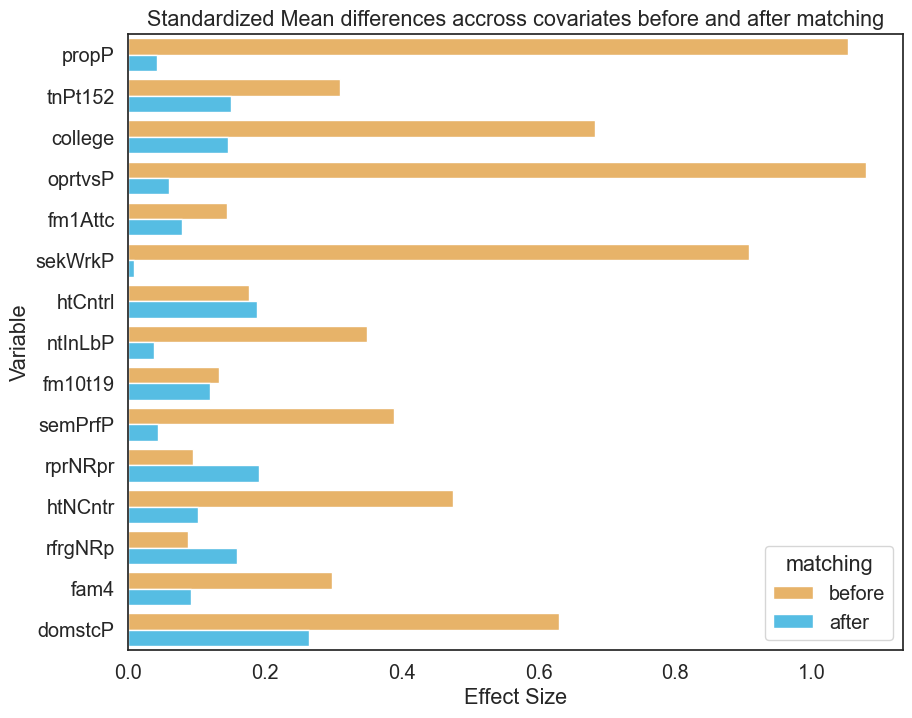

In [48]:
naive_psmpy.effect_size_plot()

In [49]:
naive_matched = retrieve_matches(naive_psmpy, naive)
naive_matched['log_exposure'] = np.log(5)

run_models_update_results(naive_matched, all_results, 'Naive')

all_results

Estimating an alpha of 2.115858178866054 for crashes
Checking Asumptions of Negative Binomial Model for 311s:
    	Mean 311s: 1199.4458715596331
    	Variance of 311s: 14207086.188700758
    
Estimating an alpha of 9.87431642067848 for 311s
                 Generalized Linear Model Regression Results                  
Dep. Variable:              n_crashes   No. Observations:                  561
Model:                            GLM   Df Residuals:                      559
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4158.6
Date:                Wed, 26 Mar 2025   Deviance:                       524.74
Time:                        13:36:35   Pearson chi2:                     558.
No. Iterations:                     6   Pseudo R-squ. (CS):           0.003064
Covariance Type:            nonrobust           

{'city': ['Chicago',
  'New York',
  'Detroit',
  'Los Angeles',
  'Philidelphia',
  'Pooled',
  'Naive'],
 '311_coef': [-0.3295655501158682,
  0.2681657593039798,
  -0.4769957592475861,
  0.06690786040996742,
  0.0961597243923287,
  -0.06551048004361178,
  -0.07281151460201817],
 '311_se': [0.1684162334835936,
  0.1899993571874912,
  0.28152039130150347,
  0.46129358729358916,
  0.1527781333178616,
  0.1407075357768669,
  0.2778779411531711],
 '311_p': [0.05036493641983,
  0.15812566910986448,
  0.09019765848766458,
  0.8846761435170781,
  0.5290822172697925,
  <NA>,
  0.7933006503242703],
 'crash_coef': [-0.417394776862851,
  0.29086894289114573,
  -0.23269150678843536,
  0.07106540539856228,
  -0.025520889282123066,
  -0.05504887264310056,
  0.16523146693704802],
 'crash_se': [0.214690472538398,
  0.170587165445037,
  0.22676683782356427,
  0.3933509185186149,
  0.14798879718575594,
  0.1258917624424256,
  0.12670559182551394],
 'crash_p': [0.0518749537083297,
  0.08817493711738246,

## Final Data Checking Analyses

In [ ]:
# Check number of shared important features between differing outcomes
import pandas as pd

cov_grade = pd.read_csv('../../data/outcomes/covariates_grade.csv')
cov_race = pd.read_csv('../../data/outcomes/covariates_race.csv')

cities = cov_grade.columns.tolist()

cov_grade, cov_race

(    Unnamed: 0  Chicago New York City  Detroit Los Angeles Philadelphia
 0            0    propP       mdMlScY  sekWrkP     mdMlScY      pt1p5t2
 1            1  sekWrkP       clerclP  tnPt152       propP        profP
 2            2  undrP51       nRprtRm  fm20pls     sekWrkP      ntInLbP
 3            3  fm1Dtch       tnP5175  nMjrRpr     tnPt761         fam3
 4            4  ntInLbP       fam5to9    profP       profP      tnPt761
 5            5  semPrfP       semPrfP  mdMlScY     htCntrl      oprtvsP
 6            6  domstcP        laborP    propP     hghSchl      sekWrkP
 7            7  tnPt2pl       oprtvsP  fm1Dtch     majrRpr      domstcP
 8            8  fm2Othr       tnNRprt  majrRpr     rfrgOth      hghSchl
 9            9  nRprtSc       nMjrRpr  craftsP     rprNRpr      fm1Dtch
 10          10  fm10t19       fm1Attc  pt1p5t2     htNRprt      emplydP
 11          11  noSchol         propP  fm2Othr     semPrfP      servicP
 12          12  rfrgNRp       tnUnP51  refrgNn    